In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

test_dir = 'val_data1'

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

test_dataloader = DataLoader(test_dataset, batch_size=64)

print('Testing set size:', len(test_dataset))



Testing set size: 504


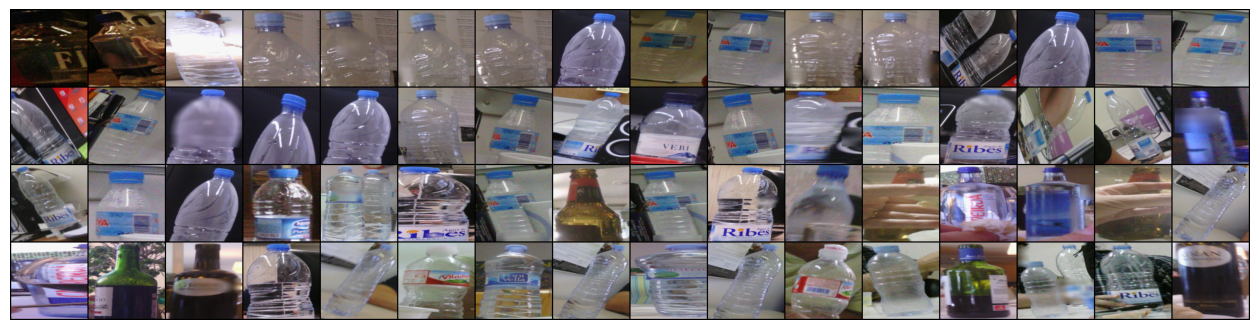

In [12]:
# visualize a sample image
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Get a batch of training data
inputs, targets = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=16)

plt.figure(figsize=(16, 10))
plt.imshow(np.transpose(out, (1, 2, 0)))
plt.axis('off')
plt.show()




In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseLayer(nn.Module):
    def __init__(self, input_features, growth_rate, bn_size=4, drop_rate=0):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu2(self.bn2(out)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        return torch.cat([x, out], 1)

class DenseBlock(nn.Module):
    def __init__(self, num_layers, input_features, growth_rate, bn_size=4, drop_rate=0):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(input_features + i * growth_rate, growth_rate, bn_size, drop_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)
    
class TransitionLayer(nn.Module):
    def __init__(self, input_features, reduction=0.5):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(input_features, int(input_features * reduction), kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(self.relu(self.bn(x)))
        out = self.pool(out)
        return out
    
class DenseNet121(nn.Module):
    def __init__(self, num_classes= 9, num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16), reduction=0.5, drop_rate=0):
        super(DenseNet121, self).__init__()
        # Initial convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Dense blocks
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(num_layers, num_features, growth_rate, drop_rate=drop_rate)
            self.features.add_module(f'denseblock{i + 1}', block)
            num_features = num_features + num_layers * growth_rate  # Total features after block
            
            if i != len(block_config) - 1:  # do not add transition layer after the last dense block
                # Correct number of input features for transition layer
                trans = TransitionLayer(num_features, reduction)
                self.features.add_module(f'transition{i + 1}', trans)
                num_features = int(num_features * reduction)  # Reduce features by reduction factor

        # Final batch normalization should be set with the correct feature size
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out




Precision: 0.84
Recall: 0.84
F1-Score: 0.84
Accuracy: 0.93


c:\Users\jhara\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


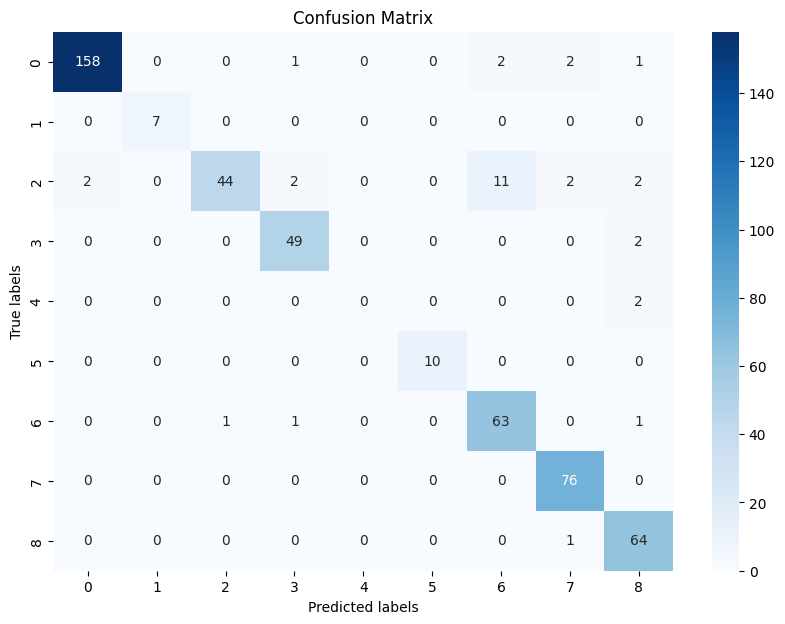

In [17]:
import torch
from torch import nn
import numpy as np
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# this code tests the accuracy for our initial model without transfer learning



# Path to model file
model_path = 'models/best_model_customDenseNet121.pth'


model = DenseNet121() 

# Load the weights from the saved file
model.load_state_dict(torch.load(model_path))
model.eval()

device = next(model.parameters()).device

def get_all_preds_labels(model, dataloader):
    all_preds = []
    all_labels = []
    
    # Disable gradient computation
    with torch.no_grad():
        for images, labels in dataloader:
            # Move images and labels to the same device as model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get the predicted classes
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels
    
    return np.array(all_preds), np.array(all_labels)

y_preds, y_true = get_all_preds_labels(model, test_dataloader)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_preds, average='macro')
recall = recall_score(y_true, y_preds, average='macro')
f1 = f1_score(y_true, y_preds, average='macro')
accuracy = accuracy_score(y_true, y_preds)  # Calculate accuracy

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_true, y_preds)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))  # Display accuracy

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()






c:\Users\jhara\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jhara\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Precision: 0.84
Recall: 0.84
F1-Score: 0.84
Accuracy: 0.94


c:\Users\jhara\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


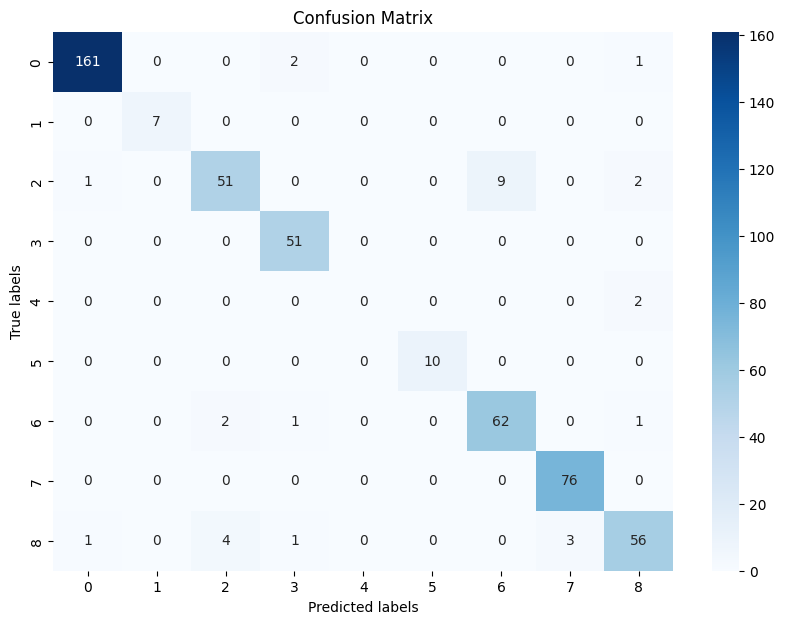

In [16]:
import torch
import torchvision.models as models
from torch import nn

# Path to  model file
model_path = 'models/best_model_TransferLearningDenseNet121.pth'


model = models.densenet121(pretrained=False)  
num_classes = 9
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)  

# Load the weights from the saved file
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode


device = next(model.parameters()).device

def get_all_preds_labels(model, dataloader):
    all_preds = []
    all_labels = []
    
    # Disable gradient computation
    with torch.no_grad():
        for images, labels in dataloader:
            # Move images and labels to the same device as model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get the predicted classes
            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(labels.cpu().numpy())  # Store true labels
    
    return np.array(all_preds), np.array(all_labels)

y_preds, y_true = get_all_preds_labels(model, test_dataloader)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_preds, average='macro')
recall = recall_score(y_true, y_preds, average='macro')
f1 = f1_score(y_true, y_preds, average='macro')
accuracy = accuracy_score(y_true, y_preds)  # Calculate accuracy

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_true, y_preds)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))  # Display accuracy

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))  
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
